# Tarea 4
Mónica Hernández Brenes

B83731

1/6/2025

## Pregunta 2

Pseudo para Algoritmos de Clasificación: LDA, QDA y Naive Bayes  

**1. LDA (Análisis Discriminante Lineal)**

**Supuestos**:
- Cada clase sigue una distribución normal multivariada.
- Todas las clases comparten la misma matriz de covarianza.

**Pasos**:

1. Calcular la media de cada clase:  
   $$
   \mu_k = \frac{1}{n_k} \sum_{i \in C_k} x_i
   $$

2. Calcular la matriz de covarianza común:  
   $$
   \Sigma = \frac{1}{n - K} \sum_{k=1}^K \sum_{i \in C_k} (x_i - \mu_k)(x_i - \mu_k)^T
   $$

3. Calcular la función discriminante:  
   $$
   \delta_k(x) = x^T \Sigma^{-1} \mu_k - \frac{1}{2} \mu_k^T \Sigma^{-1} \mu_k + \log \pi_k
   $$

4. Clasificar según:  
   $$
   \text{Clase}(x) = \arg\max_k \delta_k(x)
   $$

---

**2. QDA (Análisis Discriminante Cuadrático)**

**Supuestos**:
- Cada clase sigue una distribución normal multivariada.
- Cada clase tiene su propia matriz de covarianza.

**Pasos**:

1. Calcular la media de cada clase:  
   $$
   \mu_k = \frac{1}{n_k} \sum_{i \in C_k} x_i
   $$

2. Calcular la matriz de covarianza para cada clase:  
   $$
   \Sigma_k = \frac{1}{n_k - 1} \sum_{i \in C_k} (x_i - \mu_k)(x_i - \mu_k)^T
   $$

3. Calcular la función discriminante:  
   $$
   \delta_k(x) = -\frac{1}{2} \log |\Sigma_k| - \frac{1}{2}(x - \mu_k)^T \Sigma_k^{-1} (x - \mu_k) + \log \pi_k
   $$

4. Clasificar según:  
   $$
   \text{Clase}(x) = \arg\max_k \delta_k(x)
   $$

---

**3. Naive Bayes Gaussiano**

**Supuestos**:
- Las variables son condicionalmente independientes dadas la clase.
- Cada variable se modela como distribución normal univariada por clase.

**Pasos**:

1. Calcular media y varianza para cada variable por clase:  
   $$
   \mu_{jk},\ \sigma_{jk}^2
   $$

2. Calcular la verosimilitud por clase:  
   $$
   P(x | C_k) = \prod_{j=1}^p \frac{1}{\sqrt{2\pi \sigma_{jk}^2}} \exp\left(-\frac{(x_j - \mu_{jk})^2}{2\sigma_{jk}^2}\right)
   $$

3. Aplicar el teorema de Bayes:  
   $$
   P(C_k | x) \propto P(C_k) \cdot P(x | C_k)
   $$

4. Clasificar según:  
   $$
   \text{Clase}(x) = \arg\max_k P(C_k | x)
   $$



In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import accuracy_score


In [ ]:

# === 1. Cargar el dataset ===
df = pd.read_csv("Ejemplo_AD.csv", sep=';')
X_df = df.drop(columns=['Clase'])            
X_df = X_df.select_dtypes(include=[np.number])  
X = X_df.values                                
y = df['Clase'].values
feature_names = df.drop(columns='Clase').columns.tolist()


In [6]:

# === 2. LDA manual ===
class LDA_manual:
    def fit(self, X, y):
        self.classes = np.unique(y)
        n, d = X.shape
        self.means = {}
        self.priors = {}
        pooled_cov = np.zeros((d, d))

        for c in self.classes:
            X_c = X[y == c]
            self.means[c] = np.mean(X_c, axis=0)
            self.priors[c] = X_c.shape[0] / n
            pooled_cov += np.cov(X_c, rowvar=False) * (X_c.shape[0] - 1)

        self.cov = pooled_cov / (n - len(self.classes))
        self.inv_cov = np.linalg.inv(self.cov)

    def predict(self, X):
        predictions = []
        for x in X:
            scores = {}
            for c in self.classes:
                mu = self.means[c]
                pi = self.priors[c]
                score = x @ self.inv_cov @ mu - 0.5 * mu @ self.inv_cov @ mu + np.log(pi)
                scores[c] = score
            predictions.append(max(scores, key=scores.get))
        return np.array(predictions)


In [7]:

# === 3. QDA manual ===
class QDA_manual:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.means = {}
        self.covs = {}
        self.inv_covs = {}
        self.det_covs = {}
        self.priors = {}

        for c in self.classes:
            X_c = X[y == c]
            self.means[c] = np.mean(X_c, axis=0)
            cov = np.cov(X_c, rowvar=False)
            self.covs[c] = cov
            self.inv_covs[c] = np.linalg.inv(cov)
            self.det_covs[c] = np.linalg.det(cov)
            self.priors[c] = X_c.shape[0] / X.shape[0]

    def predict(self, X):
        predictions = []
        for x in X:
            scores = {}
            for c in self.classes:
                mu = self.means[c]
                cov_inv = self.inv_covs[c]
                cov_det = self.det_covs[c]
                term = -0.5 * np.log(cov_det) - 0.5 * (x - mu).T @ cov_inv @ (x - mu) + np.log(self.priors[c])
                scores[c] = term
            predictions.append(max(scores, key=scores.get))
        return np.array(predictions)


In [8]:

# === 4. Naive Bayes Gaussiano manual ===
class GaussianNB_manual:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.means = {}
        self.vars = {}
        self.priors = {}

        for c in self.classes:
            X_c = X[y == c]
            self.means[c] = np.mean(X_c, axis=0)
            self.vars[c] = np.var(X_c, axis=0)
            self.priors[c] = X_c.shape[0] / X.shape[0]

    def predict(self, X):
        predictions = []
        for x in X:
            probs = {}
            for c in self.classes:
                mean = self.means[c]
                var = self.vars[c]
                prior = self.priors[c]
                likelihood = np.prod(norm.pdf(x, mean, np.sqrt(var)))
                probs[c] = prior * likelihood
            predictions.append(max(probs, key=probs.get))
        return np.array(predictions)


In [12]:

# === 5. Entrenar y evaluar modelos ===
lda = LDA_manual()
lda.fit(X, y)
pred_lda = lda.predict(X)

qda = QDA_manual()
qda.fit(X, y)
pred_qda = qda.predict(X)

nb = GaussianNB_manual()
nb.fit(X, y)
pred_nb = nb.predict(X)

print("Accuracy LDA:", accuracy_score(y, pred_lda))
print("Accuracy QDA:", accuracy_score(y, pred_qda))
print("Accuracy NB :", accuracy_score(y, pred_nb))


Accuracy LDA: 0.9
Accuracy QDA: 0.9666666666666667
Accuracy NB : 0.8333333333333334


In [13]:

# === 6. PCA manual y círculo de correlaciones ===
def centro_y_pca(X):
    X_centered = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_centered, rowvar=False)
    eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:, idx]
    X_pca = X_centered @ eig_vecs[:, :2]
    return X_pca, eig_vecs[:, :2], X_centered, eig_vals[:2]

def circulo_correlaciones(X_centered, eig_vecs, eig_vals):
    stds = np.std(X_centered, axis=0)
    corr = eig_vecs * np.sqrt(eig_vals)
    corr_circle = corr / stds[:, np.newaxis]
    return corr_circle

X_pca, componentes, X_centered, lambdas = centro_y_pca(X)
correlaciones = circulo_correlaciones(X_centered, componentes, lambdas)


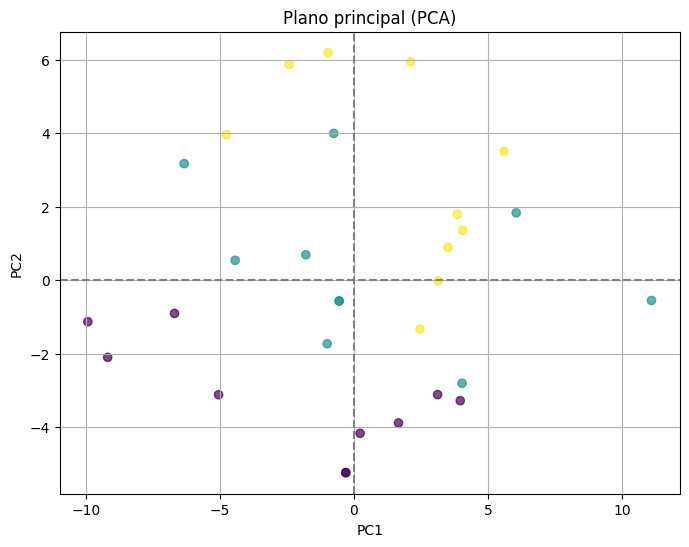

In [14]:

# === 7. Graficar plano principal ===
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=pd.factorize(y)[0], cmap='viridis', alpha=0.7)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Plano principal (PCA)")
plt.grid()
plt.show()


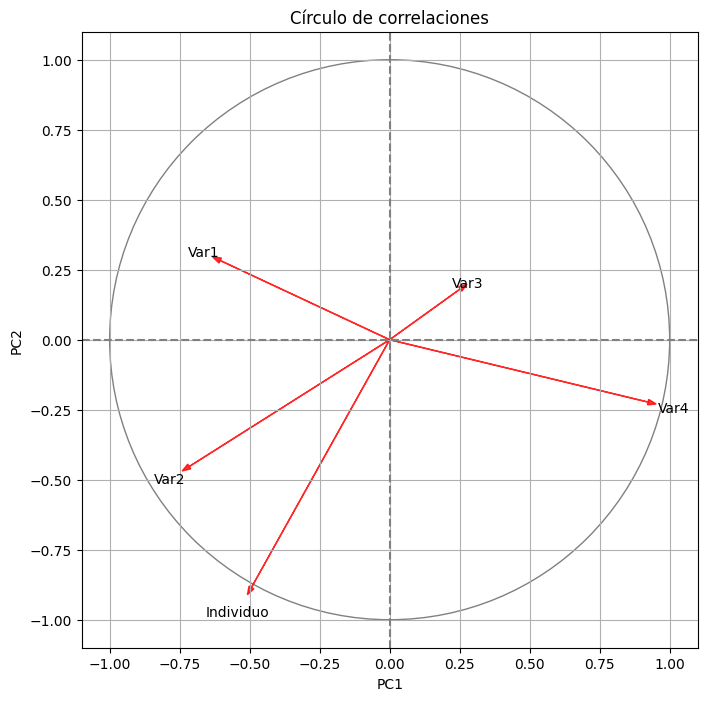

In [15]:

# === 8. Graficar círculo de correlaciones ===
plt.figure(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, color='gray', fill=False)
plt.gca().add_patch(circle)

for i in range(correlaciones.shape[0]):
    plt.arrow(0, 0, correlaciones[i, 0], correlaciones[i, 1],
              color='red', alpha=0.8, head_width=0.02)
    plt.text(correlaciones[i, 0]*1.1, correlaciones[i, 1]*1.1, feature_names[i],
             color='black', ha='center', va='center')

plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Círculo de correlaciones')
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [27]:
import pandas as pd
import numpy as np



# Cargar el CSV correctamente
df = pd.read_csv("Ejemplo_AD.csv", sep=";")

# Separar X e y correctamente
X = df.iloc[:, 1:-1]   # Desde la segunda columna hasta la penúltima (Var1 a Var5)
y = df["Clase"]        # Última columna

# Centrado
X_centered = X - X.mean()

# Convertir a matrices NumPy
X_matrix = X_centered.to_numpy()
n, p = X_matrix.shape
clases = y.unique()
r = len(clases)

# Asignar pesos iguales a cada individuo: p_i = 1/n
pi = np.ones(n) / n
D = np.diag(pi)

# Inicializar estructuras
g_dict = {}   # centros de gravedad
q_dict = {}   # pesos de cada clase

# Calcular centros de gravedad por clase y pesos q_s
for clase in clases:
    idx = y[y == clase].index
    X_sub = X_matrix[idx]
    pi_sub = pi[idx]
    q_s = pi_sub.sum()
    g_s = (pi_sub[:, None] * X_sub).sum(axis=0) / q_s
    g_dict[clase] = g_s
    q_dict[clase] = q_s

# Calcular matriz de covarianza total: V = X^T D X
V = X_matrix.T @ D @ X_matrix

# Calcular matriz de covarianza intra-clase: VW
VW = np.zeros((p, p))
for clase in clases:
    idx = y[y == clase].index
    X_sub = X_matrix[idx]
    pi_sub = pi[idx]
    g_s = g_dict[clase]
    for i in range(len(idx)):
        diff = (X_sub[i] - g_s).reshape(-1, 1)
        VW += pi_sub[i] * (diff @ diff.T)

# Calcular matriz de covarianza inter-clase: VB
VB = np.zeros((p, p))
for clase in clases:
    g_s = g_dict[clase].reshape(-1, 1)
    q_s = q_dict[clase]
    VB += q_s * (g_s @ g_s.T)

# Verificación
print("¿Se cumple V = VB + VW?:", np.allclose(V, VB + VW))

# Mostrar resultados
print("\nCentros de gravedad por clase:")
for clase in g_dict:
    print(f"g_{clase} =", g_dict[clase])

print("\nMatriz V (Total):\n", V)
print("\nMatriz VB (Inter-clase):\n", VB)
print("\nMatriz VW (Intra-clase):\n", VW)


¿Se cumple V = VB + VW?: True

Centros de gravedad por clase:
g_A = [ 3.68666667  0.84333333  1.34       -0.35       -0.4       ]
g_B = [-0.51333333  0.09333333 -0.21        0.25        0.48      ]
g_C = [-3.17333333 -0.93666667 -1.13        0.1        -0.08      ]

Matriz V (Total):
 [[10.89248889  1.10971111  3.32866667 -0.61146667 -3.0812    ]
 [ 1.10971111 10.83982222  2.405       0.47153333 -4.52153333]
 [ 3.32866667  2.405       1.91583333 -0.1175     -2.41666667]
 [-0.61146667  0.47153333 -0.1175      0.5929      1.01793333]
 [-3.0812     -4.52153333 -2.41666667  1.01793333 17.26706667]]

Matriz VB (Inter-clase):
 [[ 7.97502222  2.01117778  2.87793333 -0.57866667 -0.48906667]
 [ 2.01117778  0.53242222  0.72296667 -0.12183333 -0.07253333]
 [ 2.87793333  0.72296667  1.03886667 -0.2115     -0.18213333]
 [-0.57866667 -0.12183333 -0.2115      0.065       0.084     ]
 [-0.48906667 -0.07253333 -0.18213333  0.084       0.13226667]]

Matriz VW (Intra-clase):
 [[ 2.91746667 -0.90146667  0